### Reprojecting Raster Data

The following notebook covers tran
 - Loading Example Elevation Data
 - We
Xarray-Spatial's reproject takes in a spatially referenced source raster aligned with one coordinate reference system (crs) and transforms it into another crs, warping the shape and features and resetting the coordinates.

Let's bring in the packages we'll be using. First, we'll import the basic data manipulation packages, Numpy and Xarray, and then Rasterio and Rioxarray, two packages important for dealing with rasters and crs's.  

Then we'll get Geopandas, Spatialpandas, and some geometry classes for dealing with shapefile data and geometries.  

We'll also want datashader and some of its rendering functions for easy visualization of our generated data.

Finally, we'll import Xarray-spatial's reproject.

In [434]:
import numpy as np
import xarray as xr

import rasterio
import rioxarray

import geopandas as gpd
import spatialpandas as spd
from shapely.geometry.point import Point
from shapely.geometry.linestring import LineString

import datashader as ds
from datashader.transfer_functions import shade, stack, set_background
from datashader.colors import Elevation, viridis, inferno

from xrspatial.gdal.reprojection import reproject
from xrspatial import hillshade
from xrspatial import equal_interval
from xrspatial.utils import height_implied_by_aspect_ratio
from xrspatial.focal import mean

To get started, let's set up a shader function to render our output DataArrays overlayed with the target country shapes for the desired crs.

In [435]:
def render(agg, countries):
    elev_da = agg.copy()
    elev_da.data = elev_da.data.astype(float)
    elev_da.data[elev_da.data == 241] = np.nan

    elev_height, elev_width = elev_da.data.shape
    dst_crs = elev_da.rio.crs
    
    countries_rprj = countries.to_crs(dst_crs)
    countries_spd = spd.GeoDataFrame(countries_rprj, geometry='geometry')
    
    extent = countries_rprj.geometry.total_bounds
    W = 1000
    X = (extent[0], extent[2])
    Y = (extent[1], extent[3])
    H = height_implied_by_aspect_ratio(W, X, Y)
    
    canvas = ds.Canvas(plot_height=H,
                       plot_width=W,
                       x_range=X,
                       y_range=Y)
    
    elev_rst = canvas.raster(elev_da)  # TODO: Use Xarray-Spatial resample
    ctrs_rst = canvas.polygons(countries_spd, geometry='geometry')
    ctrs_rst.coords['x'] = elev_rst.coords['x']
    ctrs_rst.coords['y'] = elev_rst.coords['y']
    ctrs_rst.data = ds.utils.orient_array(ctrs_rst).astype('float64')
    ctrs_rst.data[ctrs_rst.data < 1] = np.nan
    
    elevation_data = mean(elev_rst.where(~np.isnan(ctrs_rst.data)))
    elevation_hillshade = mean(hillshade(elevation_data))
    
    ctrs_rst = canvas.line(countries_spd, geometry='geometry')
    ctrs_rst.coords['x'] = elev_rst.coords['x']
    ctrs_rst.coords['y'] = elev_rst.coords['y']
    ctrs_rst.data = ds.utils.orient_array(ctrs_rst).astype('float64')
    ctrs_rst.data[ctrs_rst.data < 1] = np.nan

    shade_elev = shade(elevation_data, cmap=inferno)
    shade_ctrs = shade(ctrs_rst, cmap=['white'], alpha=200)
    shade_hill = shade(elevation_hillshade, cmap=['black', 'white'], alpha=80)
    return set_background(stack(shade_elev, shade_hill), 'black')


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['pop_est'] > 0]
world

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

Now, we're ready to generate some map images.

Representing a 3D surface like the earth in a 2D map has been a challenge for a long time in cartography. Many solutions have been found, but ultimately it comes down to a compromise between distortions in distance, direction, and area. Different coordinate reference systems (crs) perform differently in these 3 metrics in different map areas.

A few of the more well-known projections follow:

The lat/lon (equirectangular) projection, EPSG:4326:  
This very common one displays meridians and parallels as equally spaced vertical and horizontal lines. Conversion between x, y coordinates on the map and earth locations are very simple, and this is a very popular one for general use. However, the significant distortions inherent to this method make it impractical for many scientific application.

Let's open an earth elevation map in this crs.

### Lat/Lon (equirectangular):

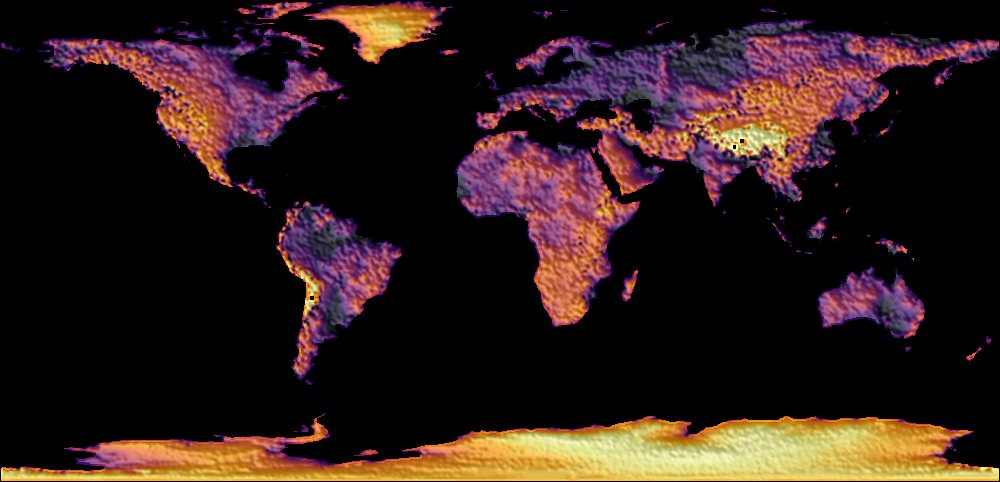

In [436]:
earth_lat_lon = (rioxarray.open_rasterio('../xrspatial/datasets/elevation.tif')
                          .drop('band')
                          .squeeze())
render(earth_lat_lon, world)

The shapes and relative sizes of the countries look like what we'd expect with this crs, as you can confirm with the neat yellow outlines around the countries.

Now, we'll use Xarray-spatial's `reproject` to reproject this map into the web mercator crs. Web mercator is a cylindrical projection and produces a conformal map (true angles), and it is the projection of choice for almost all web maps.

To perform the reprojection, we just need the EPSG code, 3857. 

### Web Mercator

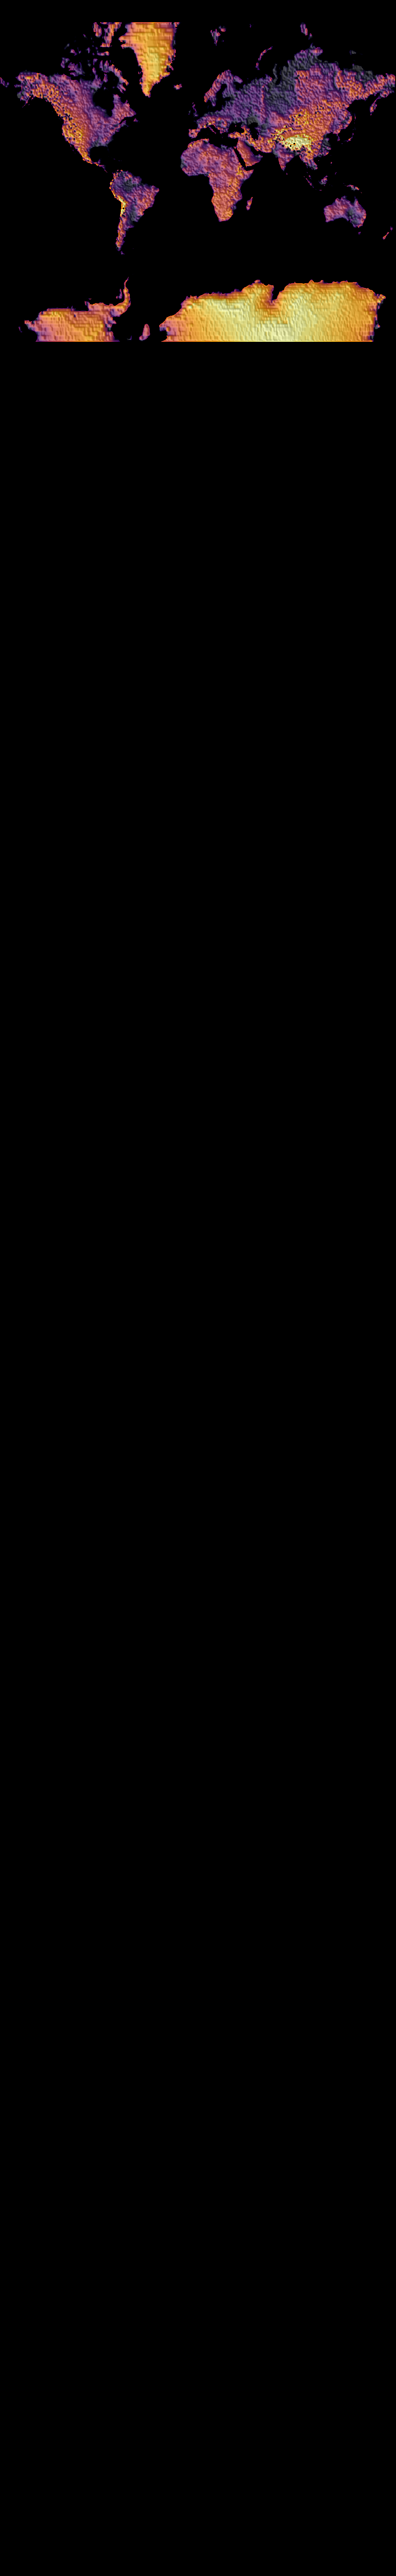

In [437]:
web_mercator_crs = 'EPSG:3857'
web_mercator_earth = reproject(earth_lat_lon, web_mercator_crs)
render(web_mercator_earth, world)
#world = world[(world.pop_est>0) & 
#              (world.name != "Antarctica")]

As you can see, this shrinks the sizes of countries closer to equator and stretches those at the poles in order to preserve the angles between directions.
As you can also see, the yellow country oulines neatly wrap the countries displayed, showing that our reprojection is returning the correct shapes. Please note the cutoffs at the top and bottom of this map; these are due to the web mercator projection not applying to latitudes above and below +/-85.06 degrees.

Now, let's try the Robinson projection. This map was designed to be "right appearing" and have a more intuitive feel to human readers, and has small distorions in all dimensions. It's code is ESRI:54030.

### Robinson

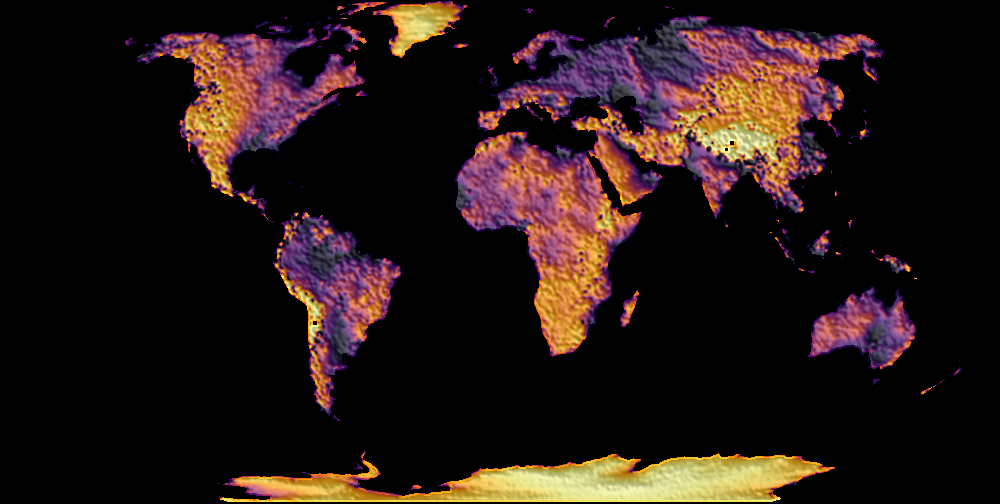

In [438]:
robinson_crs = 'ESRI:54030'
robinson_earth = reproject(earth_lat_lon, robinson_crs)
render(robinson_earth, world)

Note the 'rounded' perspective given to the map and countries, giving the appearance of viewing a spherical map, and giving room for intuitive interpretation and comprehension of relative shapes and directions. 

Another well-used one is the Transverse Mercator projection. Like the web mercator projection it's cylindrical and conformal, but the axes are switched; i.e. the earth sphere is stretched towards two parallels. It's most useful areas with small longitude ranges, such as states and counties.

### World Mollweide

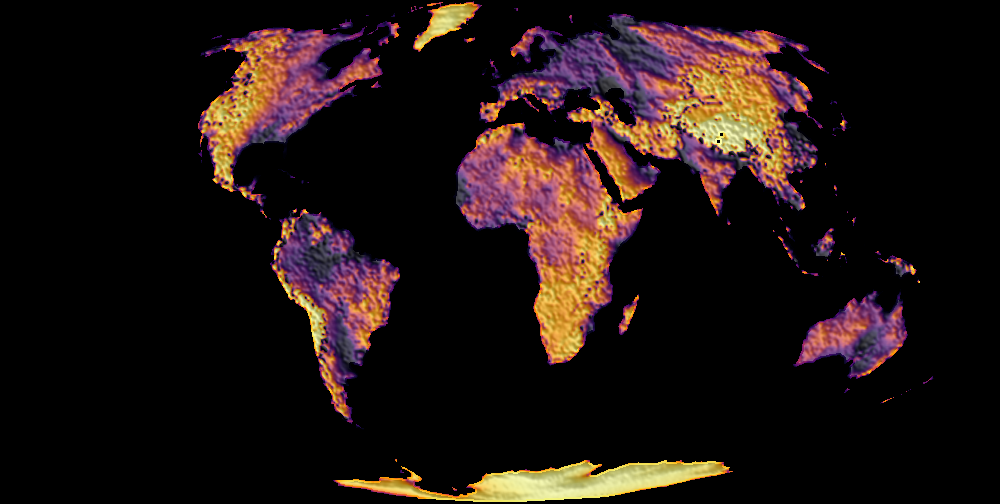

In [441]:
mollweide_epsg = 'ESRI:54009'
mollweide = reproject(earth_lat_lon, mollweide_epsg)
render(mollweide, world)

The Lambert Conformal Conic projection, which works best around middle meridians.

### World Stereographic

In [440]:
stereographic_crs = 'ESRI:54026'
stereographic_earth = reproject(earth_lat_lon, stereographic_crs)
render(stereographic_earth, world)

CPLE_AppDefinedError: Computed dimensions are too big : 3812 x inf

Another, unique, projection is the Space Oblique. This is a projection especially designed for satellite imagery so that it is completely free of distortion along the orbit path of the satellite.

### Space Oblique

/Users/brendan/miniconda3/envs/xarray-spatial/lib/python3.8/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


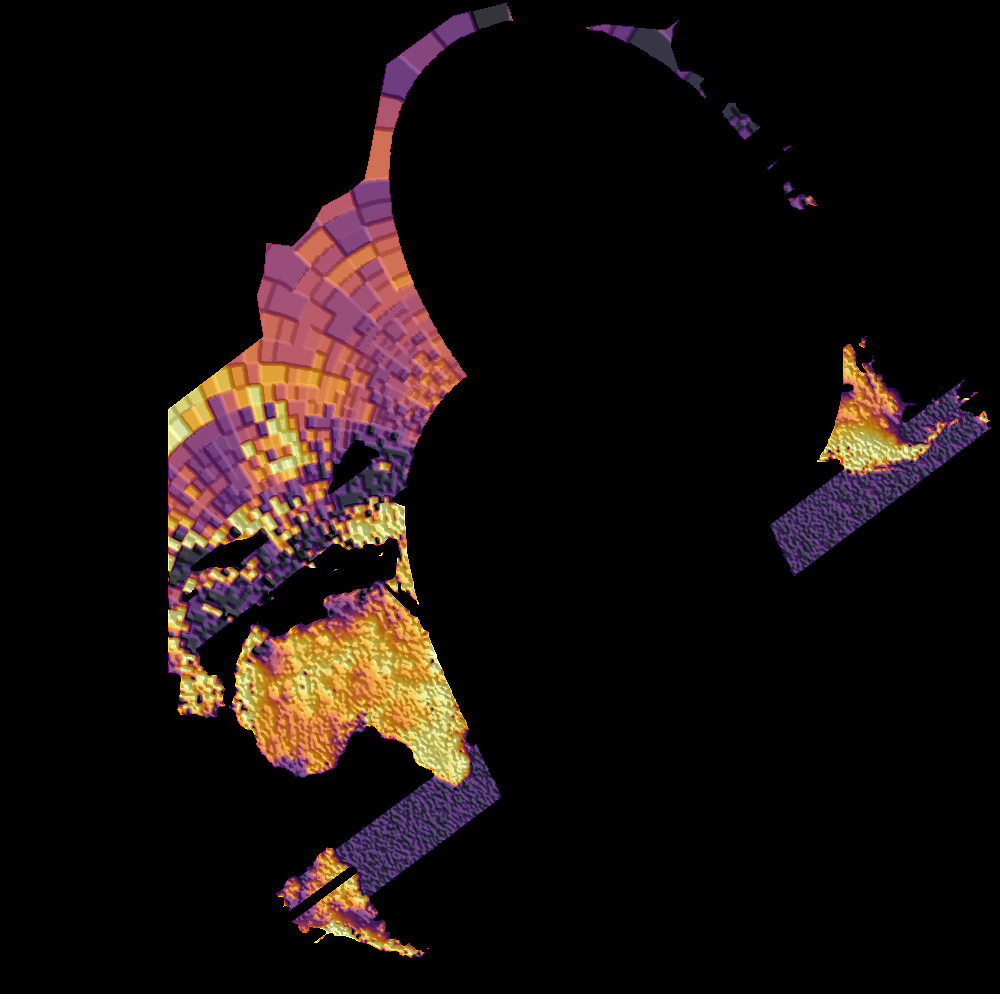

In [375]:
space_oblique_crs = 'EPSG:29873'
space_oblique_earth = reproject(earth_lat_lon, space_oblique_crs)
render(space_oblique_earth)